In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns

from keplergl import KeplerGl
import geopandas as gpd

In [33]:
loon =  'N211LB'

os.chdir("/Users/toni/Documents/TFG/og_data/DBSCAN/minptsRange/" + loon)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

raw_df = pd.concat([pd.read_csv(f) for f in all_filenames ])

In [34]:
bl = raw_df.copy()

In [35]:
bl

,ts,aircraft_id,alt,speed,Direction,registration_id,lat,lon,prev_lat,prev_lon,prev_air,prev_ts,distance_since_last_record,time_since_last_record,cluster,eps,max_distance,minpts
0,2018-04-18 17:09:10+00:00,HBAL088,64700,9,251,N211LB,-8.963215,-29.729620,NaN,NaN,NaN,NaN,0.000000,0 days 00:00:00.000000000,-1,0.000838,5.336842,2301.639344
1,2018-04-18 17:14:14+00:00,HBAL088,64600,8,255,N211LB,-8.965897,-29.741991,-8.963215,-29.729620,HBAL088,2018-04-18 17:09:10+00:00,1.391132,0 days 00:05:04.000000000,-1,0.000838,5.336842,2301.639344
2,2018-04-18 17:15:25+00:00,HBAL088,64600,9,257,N211LB,-8.966519,-29.744867,-8.965897,-29.741991,HBAL088,2018-04-18 17:14:14+00:00,0.323372,0 days 00:01:11.000000000,-1,0.000838,5.336842,2301.639344
3,2018-04-18 18:08:59+00:00,HBAL088,64400,10,240,N211LB,-9.021498,-29.865860,-8.966519,-29.744867,HBAL088,2018-04-18 17:15:25+00:00,14.627192,0 days 00:53:34.000000000,-1,0.000838,5.336842,2301.639344
4,2018-04-18 18:10:32+00:00,HBAL088,64600,10,236,N211LB,-9.023941,-29.869825,-9.021498,-29.865860,HBAL088,2018-04-18 18:08:59+00:00,0.513220,0 days 00:01:33.000000000,-1,0.000838,5.336842,2301.639344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67690,2020-06-16 23:56:40+00:00,HBAL167,56500,21,84,N211LB,-20.253891,61.002274,-20.254669,60.995899,HBAL167,2020-06-16 23:55:35+00:00,0.670638,0 days 00:01:05.000000000,7,0.000838,5.336842,1298.360656
67691,2020-06-16 23:57:42+00:00,HBAL167,56400,21,84,N211LB,-20.253250,61.008698,-20.253891,61.002274,HBAL167,2020-06-16 23:56:40+00:00,0.673930,0 days 00:01:02.000000000,7,0.000838,5.336842,1298.360656
67692,2020-06-16 23:58:43+00:00,HBAL167,56400,21,84,N211LB,-20.252701,61.015076,-20.253250,61.008698,HBAL167,2020-06-16 23:57:42+00:00,0.668148,0 days 00:01:01.000000000,7,0.000838,5.336842,1298.360656
67693,2020-06-16 23:59:43+00:00,HBAL167,56400,20,84,N211LB,-20.252132,61.021313,-20.252701,61.015076,HBAL167,2020-06-16 23:58:43+00:00,0.653716,0 days 00:01:00.000000000,7,0.000838,5.336842,1298.360656


In [36]:
cluster_info = bl.groupby(['registration_id', 'minpts'])['ts'].count().reset_index()

In [37]:
def get_num_clusters(registration_id, min_pts):
    
    return bl.loc[(bl.registration_id == registration_id)\
                  & (bl.minpts == min_pts)]['cluster'].nunique() - 1
    
cluster_info['num_clusters'] = cluster_info.apply(lambda x: get_num_clusters(x.registration_id, x.minpts),\
                                                  axis=1)

In [38]:
def get_noise_share(registration_id, num_traces, min_pts):
    
    num_noise_records = bl.loc[(bl.registration_id == registration_id) \
                               & (bl.minpts == min_pts)\
                               & (bl.cluster == -1)]['ts'].count()
    

    return num_noise_records/num_traces

cluster_info['noise_share'] = cluster_info.apply(lambda x: get_noise_share(x.registration_id,\
                                                                            x.ts, x.minpts), \
                                                                axis=1)



In [39]:
def get_cluster_share(registration_id, num_traces, min_pts):
    
    num_cluster_records = bl.loc[(bl.registration_id == registration_id) \
                               & (bl.minpts == min_pts)\
                               & (bl.cluster != -1)]['ts'].count()
    

    return num_cluster_records/num_traces

cluster_info['cluster_share'] = cluster_info.apply(lambda x: get_cluster_share(x.registration_id,\
                                                                            x.ts, x.minpts), \
                                                                axis=1)

In [40]:
def get_largest_component(registration_id, num_traces, min_pts):
    
    # Noise is not a real cluster so we exclude it
    eps_df = bl.loc[(bl.registration_id == registration_id) & (bl.minpts == min_pts)\
                    & (bl.cluster != -1)]
    
    biggest_cluster = eps_df.groupby(['registration_id', 'minpts', 'cluster'])['ts'].count().max()

    return biggest_cluster/num_traces

cluster_info['largest_component_share'] = cluster_info.apply(lambda x: get_largest_component(x.registration_id,\
                                                                                       x.ts, x.minpts), \
                                                         axis=1)


In [41]:
cluster_info

,registration_id,minpts,ts,num_clusters,noise_share,cluster_share,largest_component_share
0,N211LB,177.049180,67695,17,0.014226,0.985774,0.171106
1,N211LB,295.081967,67695,20,0.070286,0.929714,0.158594
2,N211LB,472.131148,67695,20,0.141281,0.858719,0.158062
3,N211LB,590.163934,67695,21,0.179511,0.820489,0.156496
4,N211LB,708.196721,67695,18,0.227934,0.772066,0.156378
5,N211LB,885.245902,67695,15,0.302578,0.697422,0.137026
6,N211LB,1003.278689,67695,13,0.352389,0.647611,0.128030
7,N211LB,1180.327869,67695,10,0.419750,0.580250,0.126597
8,N211LB,1298.360656,67695,8,0.465263,0.534737,0.126272
9,N211LB,1416.393443,67695,8,0.472191,0.527809,0.126021


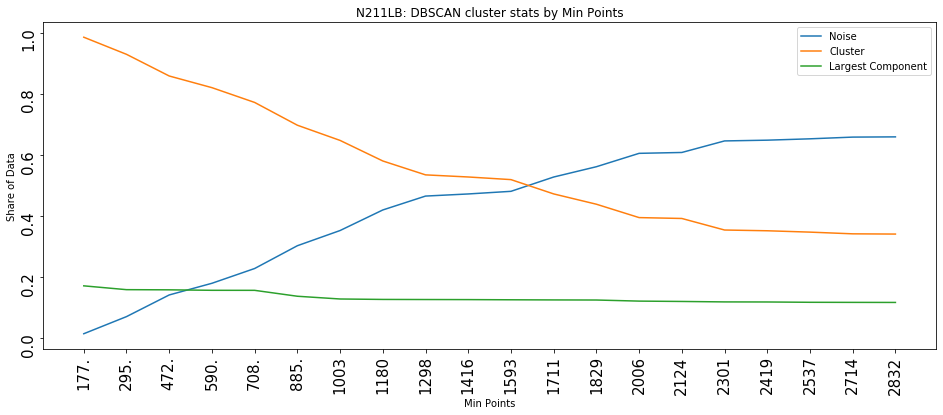

In [42]:
plt.figure(loon, figsize=(16,6))

cluster_info['minpts'] = cluster_info.minpts.astype(str)

ax = sns.lineplot(x=cluster_info['minpts'].astype(str).str[:4], y="noise_share", sort=False, label='Noise',\
                 data=cluster_info)

ax = sns.lineplot(x=cluster_info['minpts'].astype(str).str[:4], y="cluster_share", sort=False, label='Cluster',\
                 data=cluster_info, ax=ax)

ax = sns.lineplot(x=cluster_info['minpts'].astype(str).str[:4], y="largest_component_share", sort=False, label='Largest Component',\
                 data=cluster_info, ax=ax)

#ax.set(ylim=(0, 50))
dummy = ax.set_ylabel('Share of Data')
dummy = ax.set_xlabel('Min Points')
dummy = ax.set_title(loon + ': DBSCAN cluster stats by Min Points')
dummy = ax.tick_params(labelsize=15, rotation = 90)

ax.figure.savefig("/Users/toni/Desktop/DBSCAN-MINPTS-FIGURES/" + loon + "-NOISE.png", bbox_inches = "tight")


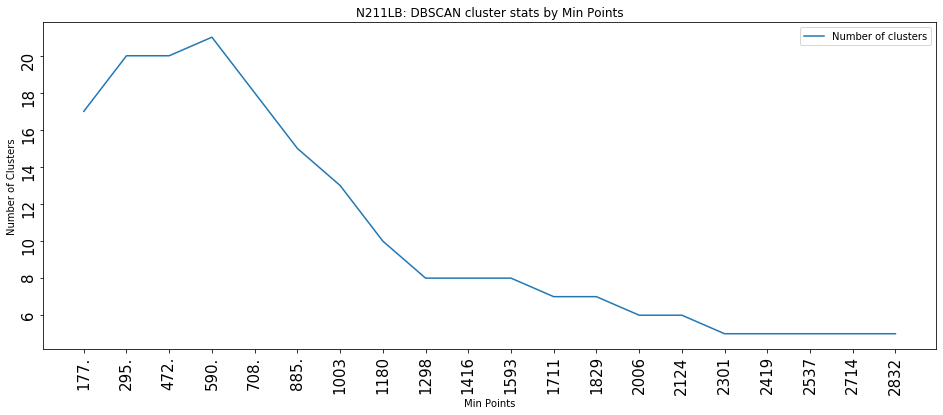

In [43]:
plt.figure(loon, figsize=(16,6))

cluster_info['minpts'] = cluster_info.minpts.astype(str)

ax = sns.lineplot(x=cluster_info['minpts'].astype(str).str[:4], y="num_clusters", sort=False, \
                  label='Number of clusters', data=cluster_info)


#ax.set(ylim=(0, 50))
dummy = ax.set_ylabel('Number of Clusters')
dummy = ax.set_xlabel('Min Points')
#dummy = ax.set_xticks(cluster_info['minpts'].astype(str).str[:4])
dummy = ax.set_title(loon + ': DBSCAN cluster stats by Min Points')
dummy = ax.tick_params(labelsize=15, rotation = 90)

ax.figure.savefig("/Users/toni/Desktop/DBSCAN-MINPTS-FIGURES/" + loon + "-NCLUS.png", bbox_inches = "tight")


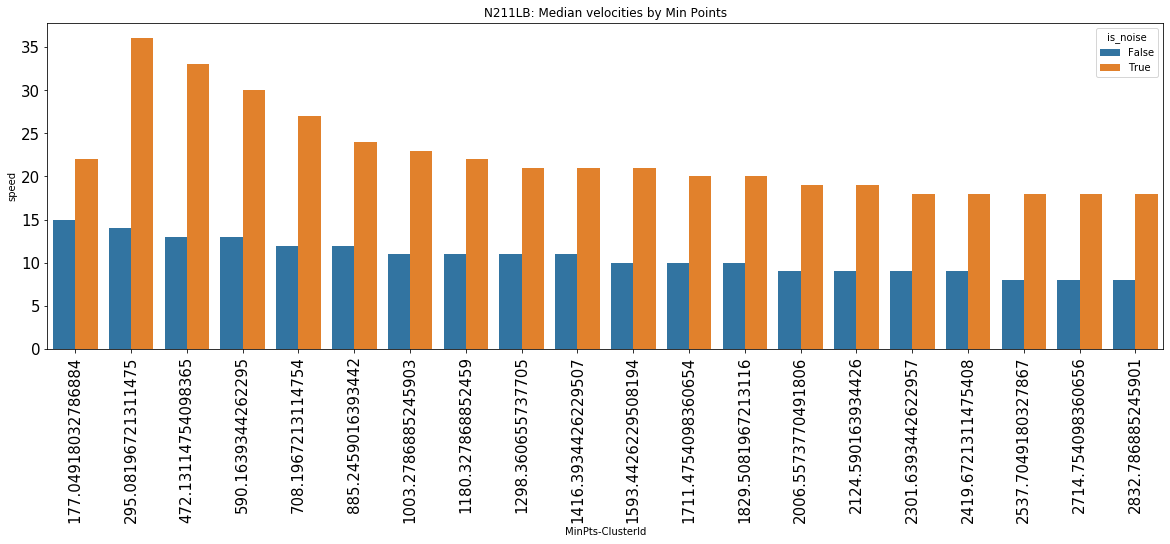

In [44]:
bl['is_noise'] = bl['cluster'].apply(lambda x: True if x == -1 else False)

target_velocities = bl.loc[bl.registration_id == loon]\
                                .groupby(['registration_id', 'minpts', 'is_noise'])['speed']\
                                .median().reset_index()

plt.figure(loon, figsize=(20,6))

ax = sns.barplot(x=target_velocities['minpts'], y="speed", hue='is_noise',\
                data=target_velocities)

#ax.set(ylim=(0, 50))
dummy = ax.set_ylabel('speed')
dummy = ax.set_xlabel('MinPts-ClusterId')
dummy = ax.set_title(loon + ': Median velocities by Min Points')
dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
dummy = ax.tick_params(labelsize=15)

ax.figure.savefig("/Users/toni/Desktop/DBSCAN-MINPTS-FIGURES/" + loon + "-VEL.png", bbox_inches = "tight")



In [45]:
bl.minpts.unique().astype(str)

array(['2301.6393442622957', '1003.2786885245903', '1829.5081967213116',
       '177.04918032786884', '1180.327868852459', '2714.754098360656',
       '2537.7049180327867', '708.1967213114754', '2832.786885245901',
       '590.1639344262295', '1416.3934426229507', '1711.4754098360654',
       '885.2459016393442', '2124.590163934426', '472.13114754098365',
       '2006.5573770491806', '295.08196721311475', '1593.4426229508194',
       '2419.6721311475408', '1298.360655737705'], dtype='<U32')

In [15]:
#Create a basemap 
map = KeplerGl(height=700, width=800)#show the map
map

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(height=700)

In [46]:
# Create a geodataframe
#bl_kepler = bl.loc[(bl.minpts > 1700) & (bl.minpts < 2200)]
#minpts_to_show = ['885.2459016393442', '1416.3934426229507', '2714.754098360656', '2301.6393442622957']
#bl_kepler = bl.loc[bl.minpts.astype(str).isin(minpts_to_show)].copy()

bl['minpts'] = bl['minpts'].astype(str)

minpts_to_show = ['14']
bl['minpts_r'] = bl['minpts'].str[:2]
bl_kepler = bl.loc[bl.minpts_r.isin(minpts_to_show)].copy()


gdf = gpd.GeoDataFrame(bl_kepler, geometry=gpd.points_from_xy(bl_kepler.lon, bl_kepler.lat))

map.add_data(data=gdf, name="loon traces")



/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [47]:
bl_kepler

,ts,aircraft_id,alt,speed,Direction,registration_id,lat,lon,prev_lat,prev_lon,...,prev_ts,distance_since_last_record,time_since_last_record,cluster,eps,max_distance,minpts,is_noise,minpts_r,geometry
0,2018-04-18 17:09:10+00:00,HBAL088,64700,9,251,N211LB,-8.963215,-29.729620,NaN,NaN,...,NaN,0.000000,0 days 00:00:00.000000000,-1,0.000838,5.336842,1416.3934426229507,True,14,POINT (-29.72962 -8.96321)
1,2018-04-18 17:14:14+00:00,HBAL088,64600,8,255,N211LB,-8.965897,-29.741991,-8.963215,-29.729620,...,2018-04-18 17:09:10+00:00,1.391132,0 days 00:05:04.000000000,-1,0.000838,5.336842,1416.3934426229507,True,14,POINT (-29.74199 -8.96590)
2,2018-04-18 17:15:25+00:00,HBAL088,64600,9,257,N211LB,-8.966519,-29.744867,-8.965897,-29.741991,...,2018-04-18 17:14:14+00:00,0.323372,0 days 00:01:11.000000000,-1,0.000838,5.336842,1416.3934426229507,True,14,POINT (-29.74487 -8.96652)
3,2018-04-18 18:08:59+00:00,HBAL088,64400,10,240,N211LB,-9.021498,-29.865860,-8.966519,-29.744867,...,2018-04-18 17:15:25+00:00,14.627192,0 days 00:53:34.000000000,-1,0.000838,5.336842,1416.3934426229507,True,14,POINT (-29.86586 -9.02150)
4,2018-04-18 18:10:32+00:00,HBAL088,64600,10,236,N211LB,-9.023941,-29.869825,-9.021498,-29.865860,...,2018-04-18 18:08:59+00:00,0.513220,0 days 00:01:33.000000000,-1,0.000838,5.336842,1416.3934426229507,True,14,POINT (-29.86982 -9.02394)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67690,2020-06-16 23:56:40+00:00,HBAL167,56500,21,84,N211LB,-20.253891,61.002274,-20.254669,60.995899,...,2020-06-16 23:55:35+00:00,0.670638,0 days 00:01:05.000000000,7,0.000838,5.336842,1416.3934426229507,False,14,POINT (61.00227 -20.25389)
67691,2020-06-16 23:57:42+00:00,HBAL167,56400,21,84,N211LB,-20.253250,61.008698,-20.253891,61.002274,...,2020-06-16 23:56:40+00:00,0.673930,0 days 00:01:02.000000000,7,0.000838,5.336842,1416.3934426229507,False,14,POINT (61.00870 -20.25325)
67692,2020-06-16 23:58:43+00:00,HBAL167,56400,21,84,N211LB,-20.252701,61.015076,-20.253250,61.008698,...,2020-06-16 23:57:42+00:00,0.668148,0 days 00:01:01.000000000,7,0.000838,5.336842,1416.3934426229507,False,14,POINT (61.01508 -20.25270)
67693,2020-06-16 23:59:43+00:00,HBAL167,56400,20,84,N211LB,-20.252132,61.021313,-20.252701,61.015076,...,2020-06-16 23:58:43+00:00,0.653716,0 days 00:01:00.000000000,7,0.000838,5.336842,1416.3934426229507,False,14,POINT (61.02131 -20.25213)


In [18]:
'''
Loon: Chosen Min Points - Min stay time

N139LB: 1711
Comment: 

N166LB: 885
Comment:

N191LB: 1416
Comment:

N211LB: 1593
Comment: 

N221LB: 1829
Comment:

N225LB: 1593
Comment:

N226LB: 1416
Comment: 

N228LB: 1593
Comment:

N234LB: 1416
Comment:

N235LB: 2006
Comment: 

N238LB: 1593
Comment: 

N252LB: 2714
Comment:

N253LB: 1829
Comment:

N271LB: 2124
Comment:

N329LB: 2301
Comment:

N789LB: 2124
Comment:


'''

"\nLoon: Chosen Min Points - Min stay time\n\nN139LB: 1711.47\nComment: reasonable number of clusters and good cluster-noise balance\n\nN166LB: 885\n\nN211LB: 1103 \nComment: \n\nN226LB: 1299\nComment: first one to get the clusters. Next value breaks a valid cluster\n\nN235LB: 1003.27\nComment: balance between number of clusters(eliminates small ones) and largest cluster size(does not break too much Perú cluster)\n\nN238LB: 1298.36\nComment: the size of the largest cluster is at the valley. Doesn't break the main cluster\n\nN228LB: 1593.44\n\n\n"